In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode

### ORDERS

In [97]:
data_orders = pd.read_csv("db/olist_orders_dataset.csv")
data_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

Analisis de tabla
- eliminamos la hora de las fechas
- normalizamos status

In [2]:
data_orders["order_purchase_timestamp"] = pd.to_datetime(data_orders["order_purchase_timestamp"]).dt.normalize() # datetime64[ns]
data_orders["order_delivered_customer_date"] = pd.to_datetime(data_orders["order_delivered_customer_date"]).dt.normalize()
data_orders["order_estimated_delivery_date"] = pd.to_datetime(data_orders["order_estimated_delivery_date"]).dt.normalize()
data_orders["order_delivered_carrier_date"] = pd.to_datetime(data_orders["order_delivered_carrier_date"]).dt.normalize()

data_orders["order_status"] = data_orders["order_status"].apply(unidecode).str.strip().str.lower()
data_orders.shape

(99441, 8)

In [3]:
data_orders.duplicated().sum()

np.int64(0)

In [4]:
data_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04,2017-10-10,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26,2018-08-07,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08,2018-08-17,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22,2017-12-02,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14,2018-02-16,2018-02-26


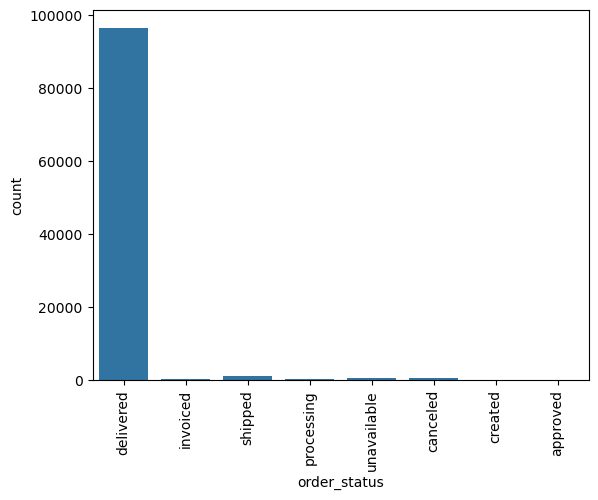

In [5]:
# Vemos que la mayoria de estados estan en delivered, asi que es razonable asumir que podemos pasar de estos estados a solo un booleano.
sns.countplot(data_orders,x= "order_status")
plt.xticks(rotation=90)  # <- AHORA VERTICAL
plt.show()

Analizamos las fechas, por si encontramos algun tipo de patron.

<Axes: xlabel='order_purchase_timestamp'>

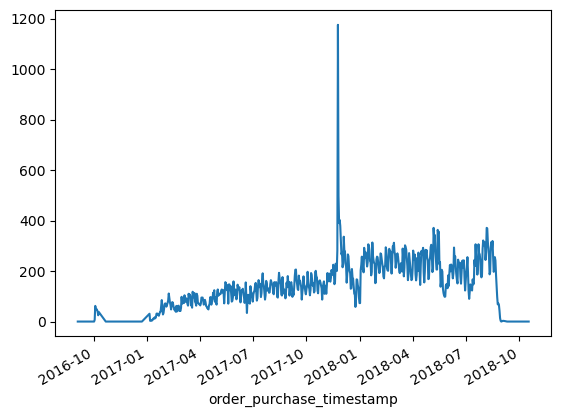

In [6]:
orders_by_date = data_orders.groupby("order_purchase_timestamp").size()
orders_by_date.plot()

In [7]:
# Posible outliner, tener cuidado para el calculo de la moda.
orders_by_date.idxmax()

Timestamp('2017-11-24 00:00:00')

In [8]:
data_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

<Axes: xlabel='order_delivered_customer_date'>

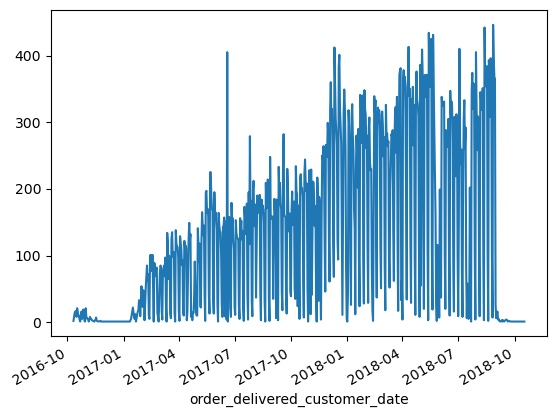

In [9]:
data_orders.groupby("order_delivered_customer_date").size().plot()

- Eliminamos columnas "order_approved_at","order_delivered_carrier_date"
- Usando "order_status" determinamos los pedidos que han sido entregados, el criterio es que si no han sido entregados, el resto de estados es razonable pensar que son negativos de cara a la satisfaccion del cliente, pues no se ha terminado el pedido.
- Calculamos el retraso de entrega usar la "order_estimated_delivery_date", "order_delivered_customer_date" y almacenarlo como numero. Siendo el tiempo entre que el usuario compra y recibe el paquete.
- Eliminamos columnas "order_estimated_delivery_date", "order_delivered_customer_date"

In [10]:
data_orders = data_orders.drop(columns = ["order_approved_at","order_delivered_carrier_date"])
data_orders.shape

(99441, 6)

In [11]:
data_orders.duplicated().sum()

np.int64(0)

In [12]:
data_orders["delivered_status"] = np.where(data_orders["order_status"] == "delivered",1,0)
data_orders["delay_time"] = (data_orders["order_estimated_delivery_date"] - data_orders["order_delivered_customer_date"]).dt.days.astype("Int64")
data_orders = data_orders.drop(columns = ["order_status", "order_estimated_delivery_date", "order_delivered_customer_date"])

<Axes: xlabel='delivered_status', ylabel='count'>

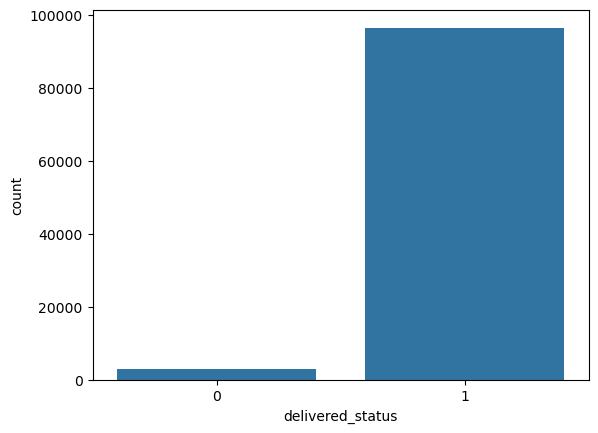

In [13]:
# Analizamos graficos de delivered_status y delay_time
sns.countplot(data=data_orders, x="delivered_status")

<Axes: xlabel='delay_time'>

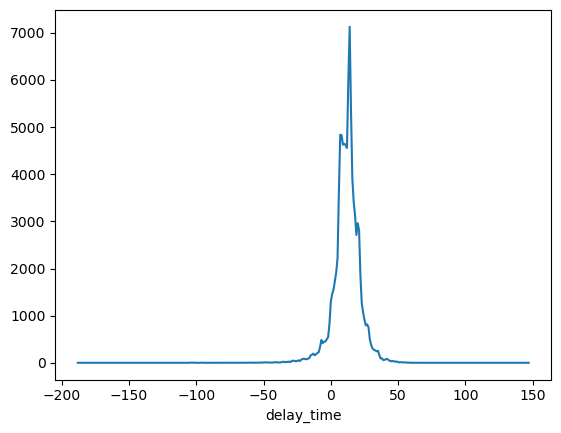

In [14]:
data_orders.groupby("delay_time").size().plot()

In [15]:
# Comprobamos que hay pedidos no entregados
data_orders.loc[data_orders["delivered_status"] == 0]

,order_id,customer_id,order_purchase_timestamp,delivered_status,delay_time
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,2017-04-11,0,<NA>
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,2018-06-04,0,<NA>
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,2018-08-03,0,<NA>
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,2017-09-03,0,<NA>
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,2018-01-10,0,<NA>
...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,2018-08-31,0,<NA>
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,2018-01-05,0,<NA>
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,2018-09-06,0,<NA>
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,2017-08-23,0,<NA>


In [16]:
# Confirmamos los tipos de las columnas
data_orders.dtypes

order_id                            object
customer_id                         object
order_purchase_timestamp    datetime64[ns]
delivered_status                     int64
delay_time                           Int64
dtype: object

In [17]:
# Revisamos nans
data_orders.isna().sum()

order_id                       0
customer_id                    0
order_purchase_timestamp       0
delivered_status               0
delay_time                  2965
dtype: int64

In [18]:
# Rellenamos con un retraso de 1000 dias para establecer que no se ha entregado, lo tendremos en cuenta de cara a la evaluacion del retraso
data_orders["delay_time"] = data_orders["delay_time"].fillna(-1000)
data_orders.isna().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
delivered_status            0
delay_time                  0
dtype: int64

<Axes: xlabel='delay_time'>

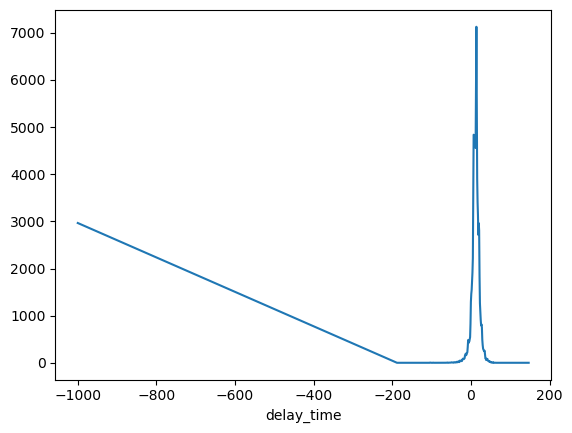

In [19]:
data_orders.groupby("delay_time").size().plot()

In [20]:
# Revisamos que no queden nulos
data_orders.isna().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
delivered_status            0
delay_time                  0
dtype: int64

### PRODUCTS + CATEGORY

In [21]:
data_products = pd.read_csv("db/olist_products_dataset.csv")
data_products = data_products.drop(columns = "product_name_lenght")
data_products.dtypes

product_id                     object
product_category_name          object
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

Creamos un diccionario con columnas y las modas de las mismas para el posterior relleno de nans.

In [22]:
measure_list = ["product_description_lenght", "product_photos_qty", "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]
mode_measures = {col: data_products[col].mode()[0] for col in measure_list}
print(mode_measures)

{'product_description_lenght': np.float64(404.0), 'product_photos_qty': np.float64(1.0), 'product_weight_g': np.float64(200.0), 'product_length_cm': np.float64(16.0), 'product_height_cm': np.float64(10.0), 'product_width_cm': np.float64(11.0)}


In [23]:
# Revisamos nans
data_products.isna().sum()

product_id                      0
product_category_name         610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [24]:
# Revisamos types
data_products.dtypes 

product_id                     object
product_category_name          object
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

Procedemos a hacer join con categorias tras gestionar varios problemas.
- Rellenamos filas con los valores traducidos que faltaban.
- Unificamos con productos
- rellenamos los faltantes con Unknown

In [25]:
data_category = pd.read_csv("db/product_category_name_translation.csv")
data_category.isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

In [26]:
data_category.shape

(71, 2)

In [27]:
products_merged = data_products.merge(
    data_category,
    on = "product_category_name",
    how = "left"
)
products_merged.loc[products_merged["product_category_name_english"].isna() & ~products_merged["product_category_name"].isna()]

,product_id,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
1628,0105b5323d24fc655f73052694dbbb3a,pc_gamer,621.0,4.0,2839.0,19.0,16.0,18.0,NaN
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,284.0,1.0,1200.0,25.0,33.0,25.0,NaN
7478,6727051471a0fc4a0e7737b57bff2549,pc_gamer,1532.0,3.0,650.0,16.0,22.0,20.0,NaN
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,382.0,2.0,850.0,30.0,21.0,22.0,NaN
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,927.0,1.0,10600.0,40.0,20.0,38.0,NaN
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,792.0,4.0,750.0,30.0,30.0,30.0,NaN
16930,dbe520fb381ad695a7e1f2807d20c765,pc_gamer,840.0,6.0,800.0,18.0,22.0,22.0,NaN
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,1372.0,5.0,7350.0,40.0,30.0,23.0,NaN


In [28]:
# Encontramos nuevas categorias que no estan traducidas, procedemos a incluirlas en product category y volvemos a analizar
nuevas_filas = pd.DataFrame(
    {"product_category_name" : ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
     "product_category_name_english" : ["pc_gamer", "portable_kitchen_and_food_preparators"]
    }
)
data_category = pd.concat([data_category, nuevas_filas])
products_merged = data_products.merge(
    data_category,
    on = "product_category_name",
    how = "left"
)
data_products = products_merged
data_products["product_category_name_english"] = data_products["product_category_name_english"].fillna("unknown")
data_products

,product_id,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [29]:
data_products.isna().sum()

product_id                         0
product_category_name            610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english      0
dtype: int64

In [30]:
data_products.loc[(data_products["product_category_name_english"] == "unknown") & data_products["product_category_name"].isna()]

,product_id,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,650.0,17.0,14.0,12.0,unknown
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,300.0,16.0,7.0,20.0,unknown
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,200.0,20.0,20.0,20.0,unknown
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,18500.0,41.0,30.0,41.0,unknown
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,300.0,35.0,7.0,12.0,unknown
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,1800.0,30.0,20.0,70.0,unknown
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,800.0,30.0,10.0,23.0,unknown
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,200.0,21.0,8.0,16.0,unknown
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,1300.0,45.0,16.0,45.0,unknown


In [31]:
# Nos quedamos unicamente con la columna localizada en ingles, y encontramos que hay algunas filas que ya carecian de categoria.
products_merged.drop(columns = "product_category_name", inplace = True)

In [32]:
data_products["product_category_name_english"].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', 'unknown', 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
     

In [33]:
# Revisamos nulos
data_products.isna().sum()

product_id                         0
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english      0
dtype: int64

### CUSTOMERS

In [91]:
data_customers = pd.read_csv("db/olist_customers_dataset.csv")
data_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

Decidimos extraer el prefijo y la ciudad ya que unificaremos datos a traves de la categoria de region
- Eliminamos "customer_city" y "customer_zip_code_prefix"
- Normalizamos el estado para eliminar espacios

In [35]:
data_customers = data_customers.drop(columns = "customer_city")
data_customers["customer_state"] = data_customers["customer_state"].apply(unidecode).str.strip()
data_customers = data_customers.drop(columns ="customer_zip_code_prefix")

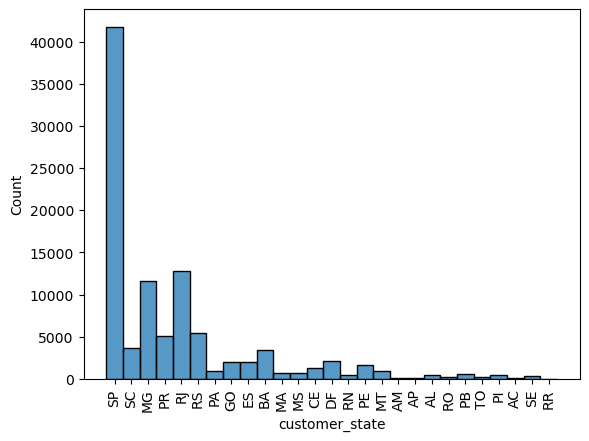

In [36]:
# Vemos una gran influencia de sao paulo, principalmente por la alta poblacion, se decide agrupar por regiones mayores
sns.histplot(data_customers, x = "customer_state")
plt.xticks(rotation=90)  # <- AHORA VERTICAL
plt.show()

In [37]:
data_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_state'], dtype='object')

### REVIEW

In [95]:
data_reviews = pd.read_csv("db/olist_order_reviews_dataset.csv")
(data_reviews.isna().sum() / data_reviews.shape[0]*100 ).round(2)

review_id                   0.00
order_id                    0.00
review_score                0.00
review_comment_title       88.34
review_comment_message     58.70
review_creation_date        0.00
review_answer_timestamp     0.00
dtype: float64

In [96]:
data_reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

<Axes: xlabel='review_score', ylabel='count'>

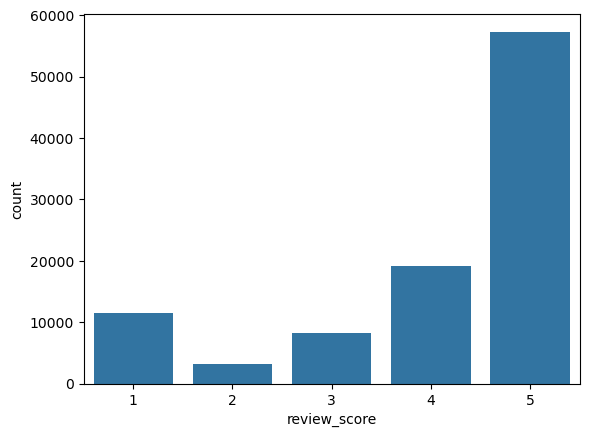

In [39]:
# Vemos un predominio del valor 4 y 5, decidimos usar el valor 5 como satisfaccion, 
# en caso de 0 1, tambien revisaremos para resultados de multiples valores,
# agrupacion, 1,2 - baja, 3,4 - media, 5 - alta
sns.countplot(data_reviews, x = "review_score")

- Eliminar columnas, de titulo y mensaje, con tal cantidad de nulos no es util en este caso
- Normalizar fechas
- Agrupar por order_id y realizas la media del score como un int, para reducir a un digito entre 1 y 5.
- Usar la ultima review como fecha.

In [40]:
data_reviews = data_reviews.drop(columns =["review_comment_title", "review_comment_message"])
data_reviews["review_creation_date"] = pd.to_datetime(data_reviews["review_creation_date"], format="%Y-%m-%d %H:%M:%S").dt.normalize()
data_reviews["review_answer_timestamp"] = pd.to_datetime(data_reviews["review_answer_timestamp"], format="%Y-%m-%d %H:%M:%S").dt.normalize()

data_reviews = (
    data_reviews
    .groupby("order_id")
    .agg(
        media_review_score=("review_score", "mean"),
        fecha_ultima_review=("review_creation_date", "max") 
    )
    .reset_index()
)

data_reviews["media_review_score"] = pd.to_numeric(data_reviews["media_review_score"], errors="coerce").astype("Float64").astype("Int64")

data_reviews.shape

(98673, 3)

In [41]:
data_reviews.isna().sum()

order_id               0
media_review_score     0
fecha_ultima_review    0
dtype: int64

In [42]:
data_reviews.head()

,order_id,media_review_score,fecha_ultima_review
0,00010242fe8c5a6d1ba2dd792cb16214,5,2017-09-21
1,00018f77f2f0320c557190d7a144bdd3,4,2017-05-13
2,000229ec398224ef6ca0657da4fc703e,5,2018-01-23
3,00024acbcdf0a6daa1e931b038114c75,4,2018-08-15
4,00042b26cf59d7ce69dfabb4e55b4fd9,5,2017-03-02


### PAYMENTS

Agrupamos por Order_id
- number_payments: numero de pagos realizados para ese order
- payment_value_sum suma de payments,
- number_payment_types el numero de pagos diferentes,
- payment_type_min elegimos un tipo de pago cualquiera.
- Si el numero de tipos de pago es mayor a 1, payment_type = multiple y si no, el minimo.
- Eliminamos las columnas "payment_type_min", "number_payment_types" una vez usadas.

In [92]:
data_pay = pd.read_csv("db/olist_order_payments_dataset.csv")
data_pay.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [43]:

data_pay_grouped = data_pay.groupby(by = "order_id").agg(
    number_payments = ("order_id", "size"),
    payment_value_sum = ("payment_value", "sum"),
    number_payment_types = ("payment_type", "nunique"),
    payment_type_min = ("payment_type", "min")).reset_index()

In [44]:
# solo hay un 2% de pagos multiples
data_pay_grouped.loc[data_pay_grouped["number_payment_types"]>1].shape[0] / data_pay_grouped.shape[0]*100

2.258648431214803

<Axes: xlabel='number_payment_types', ylabel='count'>

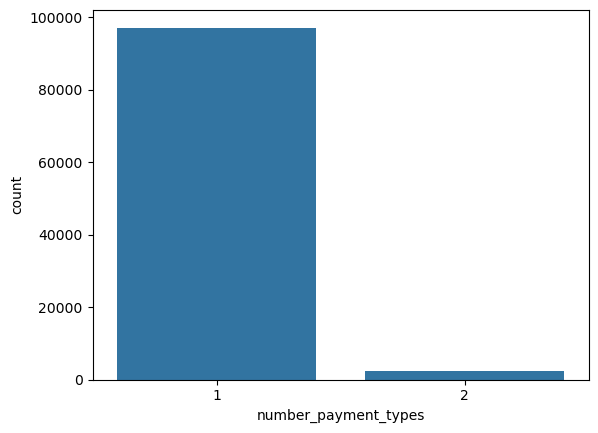

In [45]:
sns.countplot(data_pay_grouped, x = "number_payment_types")

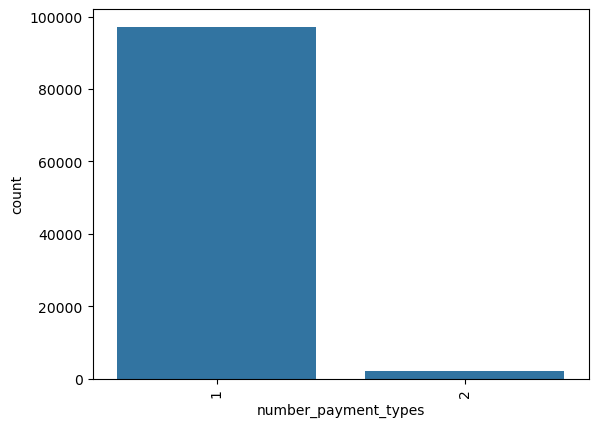

In [87]:
sns.countplot(data_pay_grouped, x = "payment_type_min")
plt.xticks(rotation=90)
plt.show()

In [47]:
data_pay_grouped = data_pay_grouped.assign(
    payment_type = np.where(
        data_pay_grouped["number_payment_types"] > 1,
        "multiple_payments",
        data_pay_grouped["payment_type_min"]
    )
)

data_pay = data_pay_grouped.drop(columns = ["payment_type_min", "number_payment_types"])
data_pay.shape

(99440, 4)

In [48]:
data_pay.head()

,order_id,number_payments,payment_value_sum,payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,1,72.19,credit_card
1,00018f77f2f0320c557190d7a144bdd3,1,259.83,credit_card
2,000229ec398224ef6ca0657da4fc703e,1,216.87,credit_card
3,00024acbcdf0a6daa1e931b038114c75,1,25.78,credit_card
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,218.04,credit_card


### ORDER - CUSTOMERS - PAY

Unificamos orders con customer y pay
- confirmamosque customer_unique_id hay repetidos y customer_id son unicos.
- Dejamos customer_unique_id, y eliminamos customer_id.

In [49]:
data_customers["customer_unique_id"].nunique()

96096

In [50]:
data_customers["customer_id"].nunique()

99441

In [51]:
data_orders.shape

(99441, 5)

In [52]:
data_orders = data_orders.merge(data_customers, on="customer_id", how = "left")
data_orders = data_orders.drop(columns = "customer_id")
data_orders.shape

(99441, 6)

In [53]:
data_orders = data_orders.merge(data_pay, on="order_id", how = "left")
data_orders.shape

(99441, 9)

In [54]:
# Encontramos que hay pedidos sin pagos asociados.
data_orders.isna().sum()

order_id                    0
order_purchase_timestamp    0
delivered_status            0
delay_time                  0
customer_unique_id          0
customer_state              0
number_payments             1
payment_value_sum           1
payment_type                1
dtype: int64

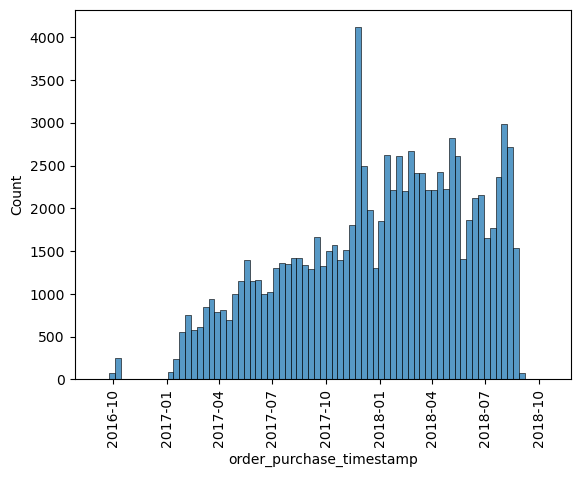

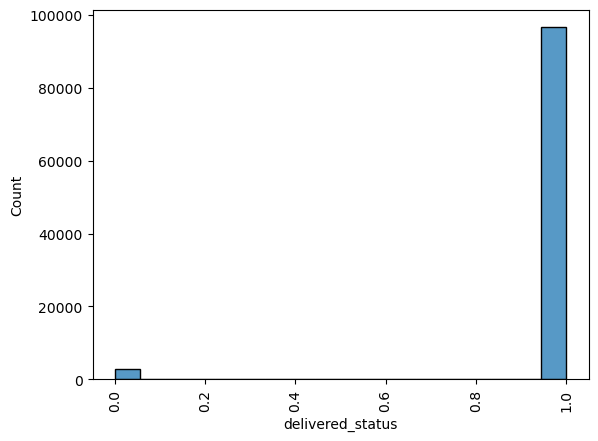

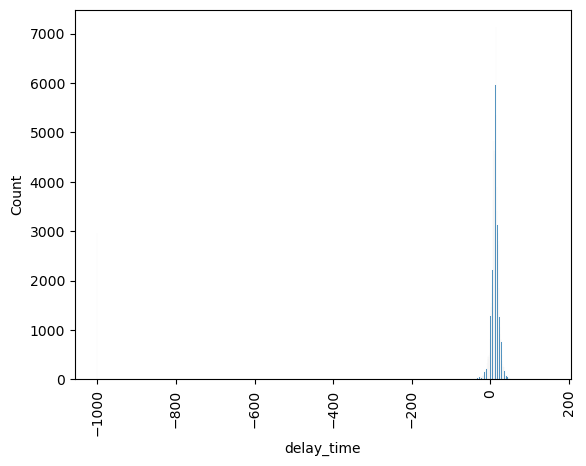

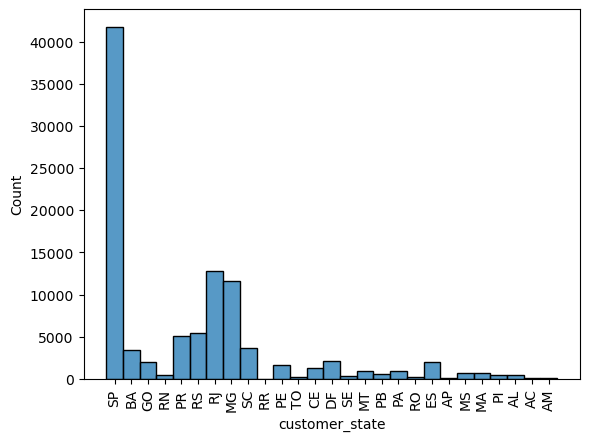

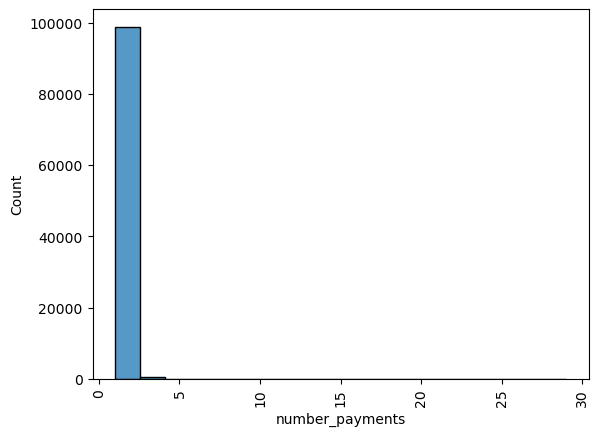

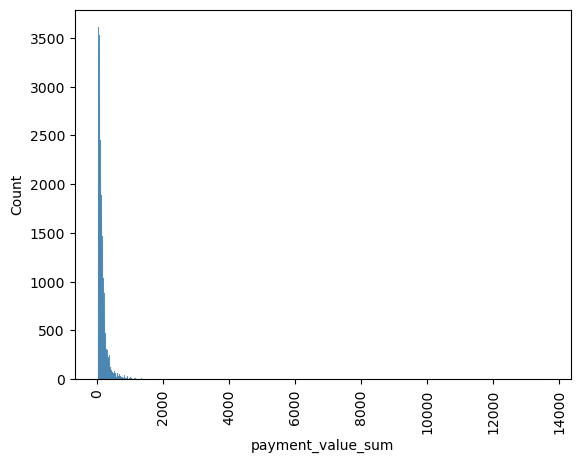

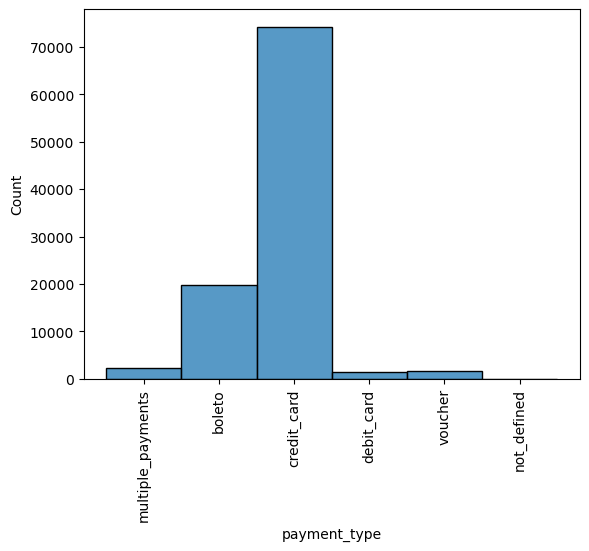

In [55]:
for col in data_orders.columns:
    if "id"not in col and "date" not in col :
        sns.histplot(data_orders, x = col)
        plt.xticks(rotation=90)  # <- AHORA VERTICAL
        plt.show()

### SELLERS

In [93]:
data_sellers = pd.read_csv("db/olist_sellers_dataset.csv")
data_sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

Eliminamos "seller_city","seller_zip_code_prefix" ya que hemos establecido la region como elemento geografico.

In [56]:
data_sellers = data_sellers.drop(columns = ["seller_city","seller_zip_code_prefix"])
data_sellers.shape




(3095, 2)

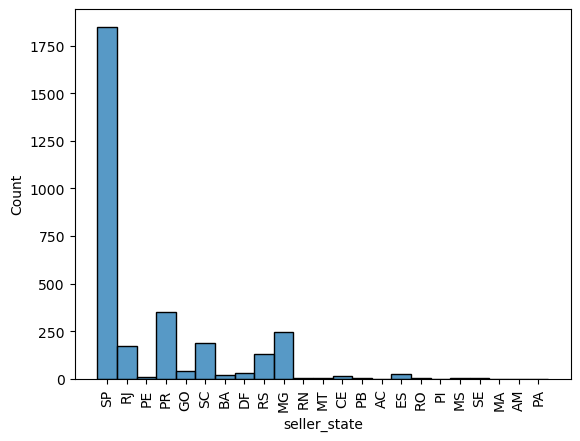

In [88]:
# Vemos una gran influencia de sao paulo, principalmente por la alta poblacion, se decide agrupar por regiones mayores
sns.histplot(data_sellers, x = "seller_state")
plt.xticks(rotation=90)
plt.show()

In [58]:
data_sellers.columns

Index(['seller_id', 'seller_state'], dtype='object')

### ITEMS + PRODUCTS

In [94]:
data_items = pd.read_csv("db/olist_order_items_dataset.csv")
data_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [59]:
data_items = data_items.merge(data_products, on = "product_id", how = "left")
data_items.shape

(112650, 14)

In [60]:
data_items.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
product_category_name_english       0
dtype: int64

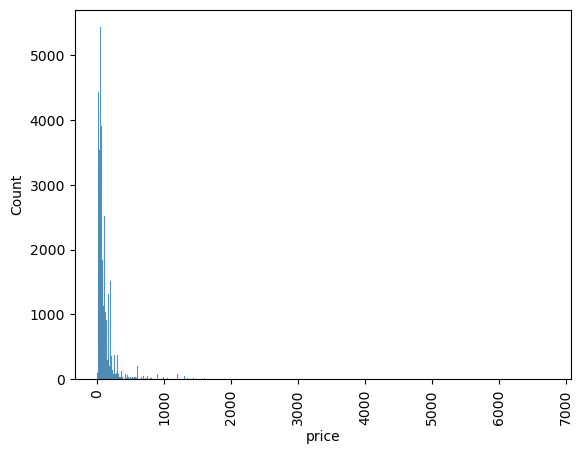

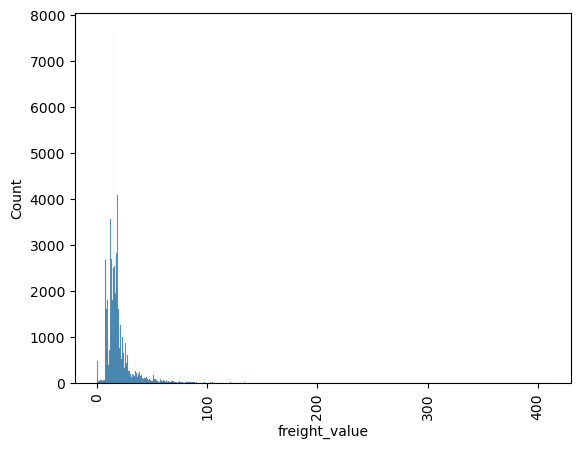

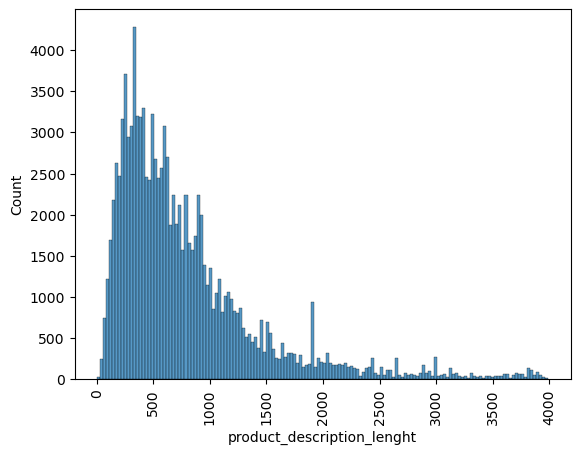

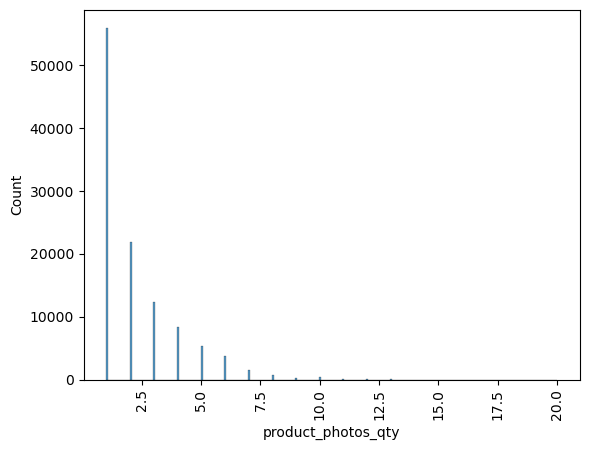

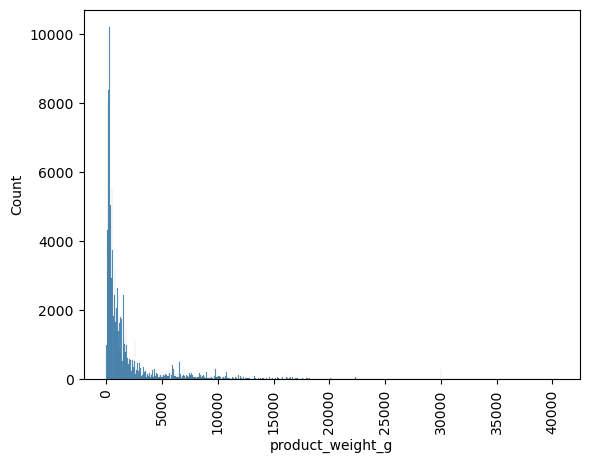

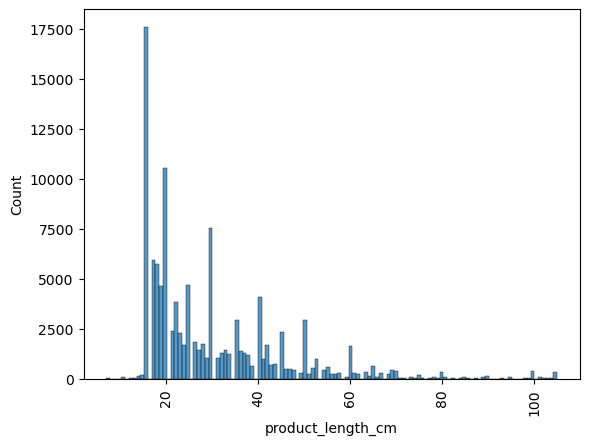

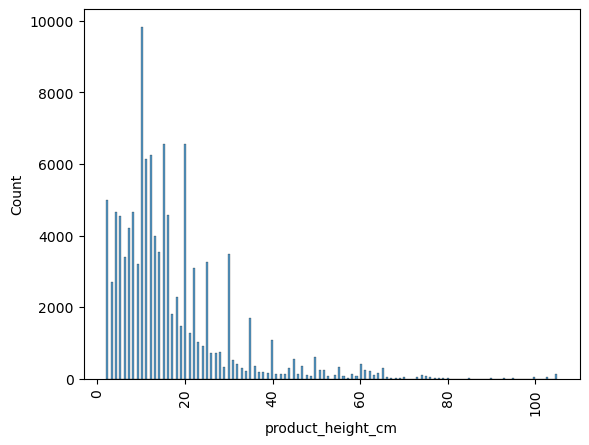

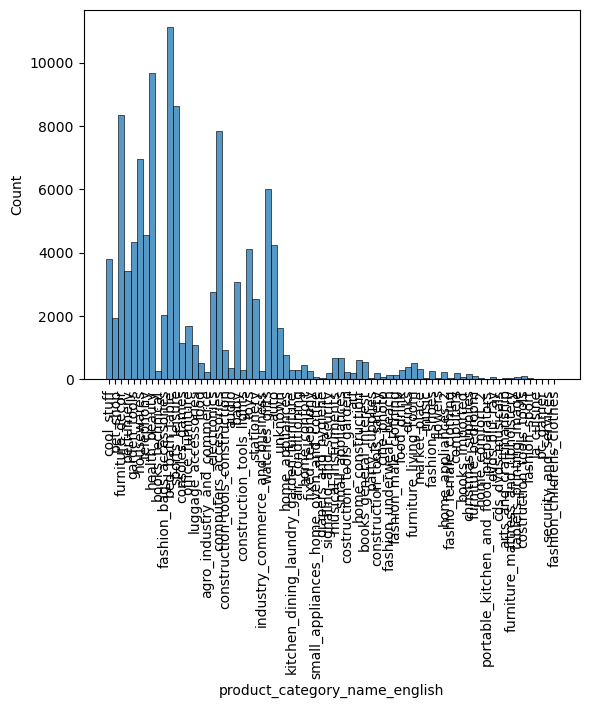

In [61]:
# analizamos precios de los items
for col in data_items.columns:
    if "id"not in col and "date" not in col :
        sns.histplot(data_items, x = col)
        plt.xticks(rotation=90)
        plt.show()

Unificamos las tablas de items y products:
- Obtenemos una columna con los valores de categoria del producto de maximo valor para cada order_id ya que hay order_id repetidos y no son nulos.
- Agrupamos los valores, la suma para precios y costes de envio.
- El numero de items diferentes dentro de cada order
- cogemos un id cualquiera, y en caso del numero de items diferentes sea mayor que 1, establecer multiple
- las medidas del producto, consideramos las maximas ya que el coste de envio dependera principalmente de ellas.
- El tratamiento de nans se hara una vez mezcladas tablas, ya que hemos encontrado que hay mas orders que items entre las dos tablas..

In [62]:
top_category = data_items.loc[
    data_items.groupby("order_id")["price"].idxmax(),
    ["order_id", "product_category_name_english"]
]

data_items_grouped = (
    data_items
    .groupby("order_id")
    .agg(
        number_items=("product_id", "size"),
        total_price=("price", "sum"),
        total_freight_value=("freight_value", "sum"),
        total_diff_items=("product_id", "nunique"),
        product_id=("product_id", "first"),
        seller_id = ("seller_id", "first"),
        product_description_lenght =("product_description_lenght","max"),
        product_photos_qty =("product_photos_qty","max"),
        product_weight_g  =("product_weight_g","max"),
        product_length_cm =("product_length_cm","max"),
        product_height_cm =("product_height_cm","max"),
        product_width_cm =("product_width_cm","max")
    )
    .reset_index()
)

data_items_grouped = data_items_grouped.merge(
    top_category, on="order_id", how="left"
)

mask = data_items_grouped["total_diff_items"] > 1

data_items_grouped.loc[mask, "product_id"] = "multiple"
data_items_grouped.loc[mask, "seller_id"] = "multiple"

data_items = data_items_grouped
data_items.isna().sum()

order_id                            0
number_items                        0
total_price                         0
total_freight_value                 0
total_diff_items                    0
product_id                          0
seller_id                           0
product_description_lenght       1389
product_photos_qty               1389
product_weight_g                   16
product_length_cm                  16
product_height_cm                  16
product_width_cm                   16
product_category_name_english       0
dtype: int64

# Data FINAL

### Merge

Unificamos tablas y analizamos cada tabla en el siguiente orden:
- Review
- Items
- Sellers

In [63]:
final_data = data_reviews.merge(data_orders, on = "order_id", how = "left")
final_data.isna().sum()

order_id                    0
media_review_score          0
fecha_ultima_review         0
order_purchase_timestamp    0
delivered_status            0
delay_time                  0
customer_unique_id          0
customer_state              0
number_payments             1
payment_value_sum           1
payment_type                1
dtype: int64

In [64]:
final_data = final_data.merge(data_items, on = "order_id", how = "left")
final_data.isna().sum()

order_id                            0
media_review_score                  0
fecha_ultima_review                 0
order_purchase_timestamp            0
delivered_status                    0
delay_time                          0
customer_unique_id                  0
customer_state                      0
number_payments                     1
payment_value_sum                   1
payment_type                        1
number_items                      756
total_price                       756
total_freight_value               756
total_diff_items                  756
product_id                        756
seller_id                         756
product_description_lenght       2135
product_photos_qty               2135
product_weight_g                  772
product_length_cm                 772
product_height_cm                 772
product_width_cm                  772
product_category_name_english     756
dtype: int64

In [65]:
final_data = final_data.merge(data_sellers, on = "seller_id", how = "left")
final_data.isna().sum()

order_id                            0
media_review_score                  0
fecha_ultima_review                 0
order_purchase_timestamp            0
delivered_status                    0
delay_time                          0
customer_unique_id                  0
customer_state                      0
number_payments                     1
payment_value_sum                   1
payment_type                        1
number_items                      756
total_price                       756
total_freight_value               756
total_diff_items                  756
product_id                        756
seller_id                         756
product_description_lenght       2135
product_photos_qty               2135
product_weight_g                  772
product_length_cm                 772
product_height_cm                 772
product_width_cm                  772
product_category_name_english     756
seller_state                     3953
dtype: int64

### Clean

In [66]:
final_data.isna().sum()

order_id                            0
media_review_score                  0
fecha_ultima_review                 0
order_purchase_timestamp            0
delivered_status                    0
delay_time                          0
customer_unique_id                  0
customer_state                      0
number_payments                     1
payment_value_sum                   1
payment_type                        1
number_items                      756
total_price                       756
total_freight_value               756
total_diff_items                  756
product_id                        756
seller_id                         756
product_description_lenght       2135
product_photos_qty               2135
product_weight_g                  772
product_length_cm                 772
product_height_cm                 772
product_width_cm                  772
product_category_name_english     756
seller_state                     3953
dtype: int64

Tras el analisis de nans rellenamos de la siguiente manera:
- Rellenamos las medidas con las modas tomadas en el diccionario que realizamos anteriormente.
- Con "unknown" product_category_name_english, seller_state, product_id, seller_id
- Confirmar que los nans de number_items, 
total_pric, 
total_freight_val, 6
total_diff_it estan en la mismas lineas.
- Siendo las mismas lineas, y un porcentaje muy bajo, se deciden eliminar para intentar desviar lo menos posible los valores dados.756

In [67]:
for col in measure_list:
    final_data[col] = final_data[col].fillna(mode_measures[col])

final_data["product_category_name_english"] = final_data["product_category_name_english"].fillna("unknown")
final_data["seller_state"] = final_data["seller_state"].fillna("unknown")
final_data["product_id"] = final_data["product_id"].fillna("unknown")
final_data["seller_id"] = final_data["seller_id"].fillna("unknown")

final_data.isna().sum()

order_id                           0
media_review_score                 0
fecha_ultima_review                0
order_purchase_timestamp           0
delivered_status                   0
delay_time                         0
customer_unique_id                 0
customer_state                     0
number_payments                    1
payment_value_sum                  1
payment_type                       1
number_items                     756
total_price                      756
total_freight_value              756
total_diff_items                 756
product_id                         0
seller_id                          0
product_description_lenght         0
product_photos_qty                 0
product_weight_g                   0
product_length_cm                  0
product_height_cm                  0
product_width_cm                   0
product_category_name_english      0
seller_state                       0
dtype: int64

In [68]:
final_data[["product_id","number_items","total_price","total_freight_value","total_diff_items"]].loc[final_data["number_items"].isna() & final_data["total_price"].isna() & final_data["total_freight_value"].isna() & final_data["total_diff_items"].isna()]

,product_id,number_items,total_price,total_freight_value,total_diff_items
24,unknown,NaN,NaN,NaN,NaN
227,unknown,NaN,NaN,NaN,NaN
247,unknown,NaN,NaN,NaN,NaN
267,unknown,NaN,NaN,NaN,NaN
305,unknown,NaN,NaN,NaN,NaN
...,...,...,...,...,...
97852,unknown,NaN,NaN,NaN,NaN
97879,unknown,NaN,NaN,NaN,NaN
98139,unknown,NaN,NaN,NaN,NaN
98196,unknown,NaN,NaN,NaN,NaN


In [69]:
final_data = final_data.dropna()
final_data.isna().sum()

order_id                         0
media_review_score               0
fecha_ultima_review              0
order_purchase_timestamp         0
delivered_status                 0
delay_time                       0
customer_unique_id               0
customer_state                   0
number_payments                  0
payment_value_sum                0
payment_type                     0
number_items                     0
total_price                      0
total_freight_value              0
total_diff_items                 0
product_id                       0
seller_id                        0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
seller_state                     0
dtype: int64

In [70]:
final_data.shape

(97916, 25)

In [71]:
# Revisamos los valores duplicados.
final_data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
98668    False
98669    False
98670    False
98671    False
98672    False
Length: 97916, dtype: bool

In [72]:
final_data.loc[final_data.duplicated(keep = False),:]

,order_id,media_review_score,fecha_ultima_review,order_purchase_timestamp,delivered_status,delay_time,customer_unique_id,customer_state,number_payments,payment_value_sum,...,product_id,seller_id,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state


In [73]:
final_data.loc[final_data["order_id"] == "03aba68b07658f28f29612641f08d4ba"]

,order_id,media_review_score,fecha_ultima_review,order_purchase_timestamp,delivered_status,delay_time,customer_unique_id,customer_state,number_payments,payment_value_sum,...,product_id,seller_id,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state
1412,03aba68b07658f28f29612641f08d4ba,4,2018-08-22,2018-08-08,1,6,c8460e4251689ba205045f3ea17884a1,RS,1.0,1202.64,...,e7cc48a9daff5436f63d3aad9426f28b,53243585a1d6dc2643021fd1853d8905,1500.0,4.0,700.0,32.0,15.0,21.0,telephony,BA


In [74]:
# Hay casos que no tienen order_id entre los items, pero si tienen valores evaluables, intentar extrapolar o analizar que hacer con esos nulos
# evaluar si tiene que ver con el delay time

### Reduccion categorias y regiones

- Se procede a reducir el mapeo regiones tanto para customer como para seller, pasando de 24 regiones a 7.
- Mapeo de Categorias, pasando de 74 a 6
- Revisar valores, nulos y tipos de las columnas.

In [75]:
final_data["seller_state"].nunique()

24

In [76]:
mapeo_categorias = {
    'SP': 'Southeast', 
    'MG': 'Southeast', 
    'ES': 'Southeast', 
    'RS': 'South', 
    'DF': 'Central-West',
    'PR': 'South', 
    'SC': 'South', 
    'RJ': 'Southeast', 
    'GO': 'Central', 
    'BA': 'Northeast',
    'MA': 'Northeast', 
    'AC': 'North', 
    'PB': 'Northeast', 
    'PE': 'Northeast', 
    'CE': 'Northeast',
    'MT': 'Central-West', 
    'PI': 'Northeast', 
    'RN': 'Northeast', 
    'MS': 'Central-West', 
    'PA': 'North', 
    'AM': 'North',
    'SE': 'Northeast', 
    'RO': 'North',
    'PE': 'Northeast',
    'RR': 'North',
    'TO': 'North',
    'GO': 'West',
    'AL': 'Northeast',
    'AP': 'North'
}

In [77]:
final_data["seller_state"] = final_data["seller_state"].replace(mapeo_categorias)
final_data["seller_state"].unique()

array(['Southeast', 'South', 'Central-West', 'unknown', 'West',
       'Northeast', 'North'], dtype=object)

In [78]:
final_data["customer_state"] = final_data["customer_state"].replace(mapeo_categorias)
final_data["customer_state"].unique()

array(['Southeast', 'South', 'West', 'Northeast', 'Central-West', 'North'],
      dtype=object)

In [79]:
final_data["product_category_name_english"].nunique()

74

In [80]:
mapeo_categorias = {
    # 1. Home and Decoration
    'furniture_decor': 'Home and Decoration', 'housewares': 'Home and Decoration', 
    'bed_bath_table': 'Home and Decoration', 'office_furniture': 'Home and Decoration',
    'home_appliances': 'Home and Decoration', 'kitchen_dining_laundry_garden_furniture': 'Home and Decoration',
    'home_confort': 'Home and Decoration', 'fixed_telephony': 'Home and Decoration',
    'small_appliances_home_oven_and_coffee': 'Home and Decoration', 'home_construction': 'Home and Decoration',
    'furniture_living_room': 'Home and Decoration', 'home_appliances_2': 'Home and Decoration',
    'furniture_bedroom': 'Home and Decoration', 'home_comfort_2': 'Home and Decoration',
    'furniture_mattress_and_upholstery': 'Home and Decoration', 'la_cuisine': 'Home and Decoration',

    # 2. Electronics and Technology
    'telephony': 'Electronics and Technology', 'electronics': 'Electronics and Technology',
    'computers_accessories': 'Electronics and Technology', 'audio': 'Electronics and Technology',
    'watches_gifts': 'Electronics and Technology', 'computers': 'Electronics and Technology',
    'portable_kitchen_and_food_preparators': 'Electronics and Technology', 'dvds_blu_ray': 'Electronics and Technology',
    'cds_dvds_musicals': 'Electronics and Technology', 'tablets_printing_image': 'Electronics and Technology',
    'pc_gamer': 'Electronics and Technology',

    # 3. Fashion and Personal Care
    'perfumery': 'Fashion and Personal Care', 'health_beauty': 'Fashion and Personal Care',
    'fashion_bags_accessories': 'Fashion and Personal Care', 'luggage_accessories': 'Fashion and Personal Care',
    'fashion_underwear_beach': 'Fashion and Personal Care', 'fashion_male_clothing': 'Fashion and Personal Care',
    'fashion_shoes': 'Fashion and Personal Care', 'fashio_female_clothing': 'Fashion and Personal Care',
    'fashion_sport': 'Fashion and Personal Care', 'fashion_childrens_clothes': 'Fashion and Personal Care',
    'diapers_and_hygiene': 'Fashion and Personal Care', 'baby': 'Fashion and Personal Care',

    # 4. Leisure, Toys and Arts
    'sports_leisure': 'Leisure, Toys and Arts', 'consoles_games': 'Leisure, Toys and Arts',
    'toys': 'Leisure, Toys and Arts', 'musical_instruments': 'Leisure, Toys and Arts',
    'art': 'Leisure, Toys and Arts', 'books_general_interest': 'Leisure, Toys and Arts',
    'books_technical': 'Leisure, Toys and Arts', 'books_imported': 'Leisure, Toys and Arts',
    'party_supplies': 'Leisure, Toys and Arts', 'cine_photo': 'Leisure, Toys and Arts',
    'music': 'Leisure, Toys and Arts', 'arts_and_craftmanship': 'Leisure, Toys and Arts',

    # 5. Tools and Construction
    'garden_tools': 'Tools and Construction', 'construction_tools_construction': 'Tools and Construction',
    'construction_tools_lights': 'Tools and Construction', 'industry_commerce_and_business': 'Tools and Construction',
    'air_conditioning': 'Tools and Construction', 'signaling_and_security': 'Tools and Construction',
    'small_appliances': 'Tools and Construction', 'costruction_tools_garden': 'Tools and Construction',
    'construction_tools_safety': 'Tools and Construction', 'costruction_tools_tools': 'Tools and Construction',
    'security_and_services': 'Tools and Construction', 'agro_industry_and_commerce': 'Tools and Construction',

    # 6. Miscellaneous and Other Items
    'cool_stuff': 'Miscellaneous and Other Items', 'pet_shop': 'Miscellaneous and Other Items',
    'food': 'Miscellaneous and Other Items', 'food_drink': 'Miscellaneous and Other Items',
    'drinks': 'Miscellaneous and Other Items', 'stationery': 'Miscellaneous and Other Items',
    'auto': 'Miscellaneous and Other Items', 'unknown': 'Miscellaneous and Other Items',
    'market_place': 'Miscellaneous and Other Items', 'flowers': 'Miscellaneous and Other Items',
    'christmas_supplies': 'Miscellaneous and Other Items'
}

final_data["product_category_name_english"] = final_data["product_category_name_english"].replace(mapeo_categorias)
final_data["product_category_name_english"].nunique()

6

In [81]:
final_data.dtypes

order_id                                 object
media_review_score                        Int64
fecha_ultima_review              datetime64[ns]
order_purchase_timestamp         datetime64[ns]
delivered_status                          int64
delay_time                                Int64
customer_unique_id                       object
customer_state                           object
number_payments                         float64
payment_value_sum                       float64
payment_type                             object
number_items                            float64
total_price                             float64
total_freight_value                     float64
total_diff_items                        float64
product_id                               object
seller_id                                object
product_description_lenght              float64
product_photos_qty                      float64
product_weight_g                        float64
product_length_cm                       

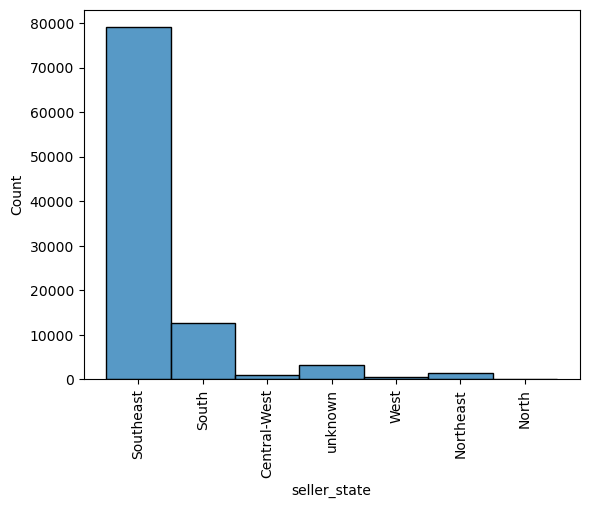

In [82]:
sns.histplot(final_data, x = "seller_state")
plt.xticks(rotation=90)
plt.show()

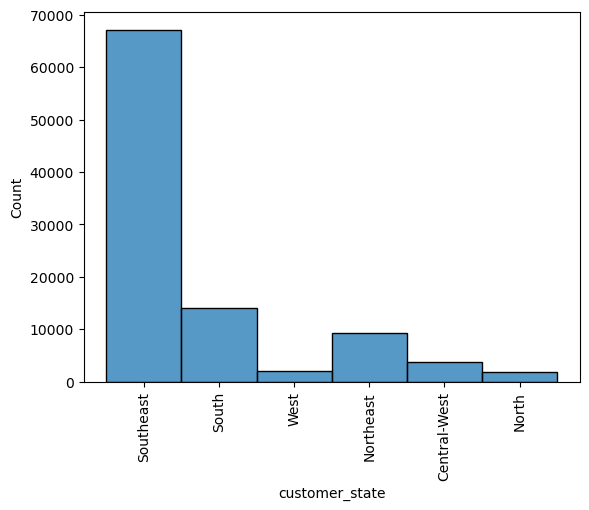

In [83]:
sns.histplot(final_data, x = "customer_state")
plt.xticks(rotation=90)  # <- AHORA VERTICAL
plt.show()

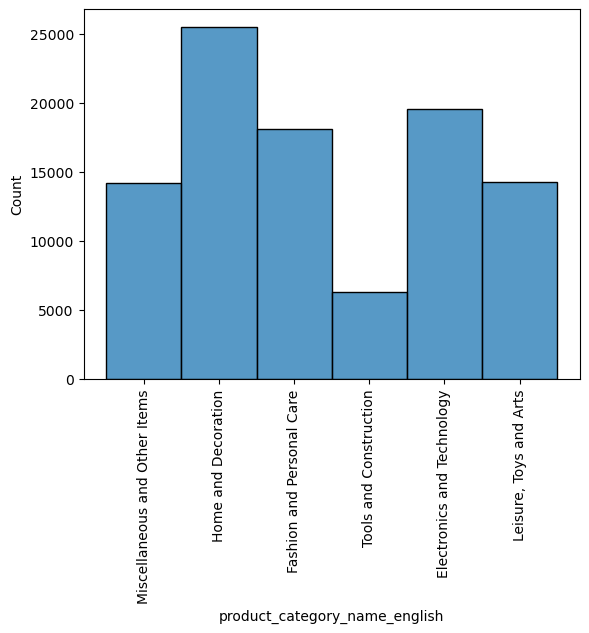

In [84]:
sns.histplot(final_data, x = "product_category_name_english")
plt.xticks(rotation=90)  # <- AHORA VERTICAL
plt.show()

### Guardado

In [85]:
final_data.to_csv("final_data.csv")

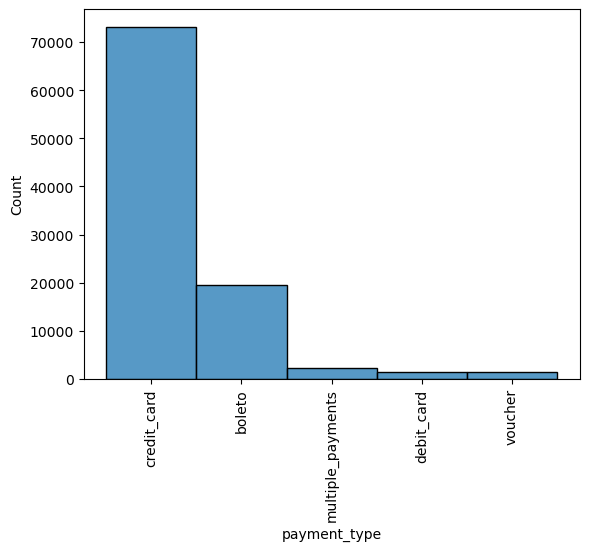

In [89]:
sns.histplot(final_data, x = "payment_type")
plt.xticks(rotation=90)  # <- AHORA VERTICAL
plt.show()

In [98]:
final_data["product_category_name_english"].unique()

array(['Miscellaneous and Other Items', 'Home and Decoration',
       'Fashion and Personal Care', 'Tools and Construction',
       'Electronics and Technology', 'Leisure, Toys and Arts'],
      dtype=object)